# Data Leakage
## Introduction
**Data leakage (or leakage)** happens when your training data <u>contains information about the target, but similar data will not be available when the model is used for prediction.</u> This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: **target leakage** and **train-test contamination**.
## target leakage
**Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

An example will be helpful. Imagine you want to <span style="color:red">
***predict who will get sick with pneumonia***
</span>. The top few rows of your raw data look like this:

|got_pneumonia|age|weight|male|took_antibiotic_medicine|...|
|:----:|:----:|:----:|:----:|:----:|:----:|
|False|65|100|False|False|...|
|False|72|130|True|False|...|
|True|58|100|False|True|...|

People take antibiotic medicines after getting pneumonia in order to recover. The raw data:


1. <span style="color:blue">shows ***a strong relationship*** between those columns, but </span>
2. `took_antibiotic_medicine` is frequently changed <span style="color:red">*after*</span> the value for `got_pneumonia` is determined. This is **target leakage**.

The model would see that anyone who has a value of False for `took_antibiotic_medicine` didn't have pneumonia. Since validation data comes from the same source as training data, the pattern will repeat itself in validation, and the model will have great validation (or cross-validation) scores.

But the model will be very inaccurate when subsequently deployed ***in the real world***, because even patients who will get pneumonia won't have received antibiotics yet when we need to make predictions about their future health.

To prevent this type of data leakage, <span style="color:blue">******any variable updated (or created) after the target value is realized should be excluded.******</span>
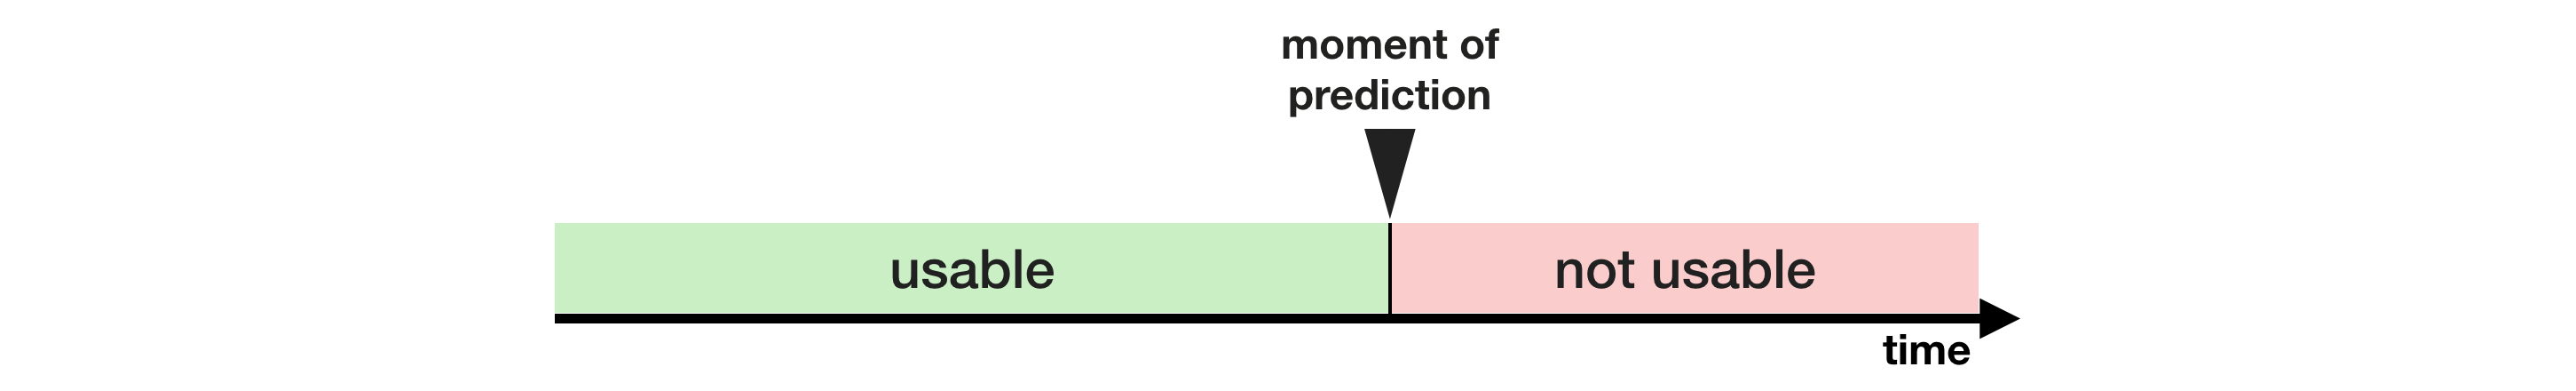

## Example
In this example, you will learn one way to detect and remove target leakage.

We will use a dataset about credit card applications and skip the basic data set-up code. The end result is that information about each credit card application is stored in a DataFrame `X`. We'll use it to predict which applications were accepted in a Series `y`

In [15]:
import pandas as pd

# Read the data
data = pd.read_csv('./AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


`true_values = ['yes']`: This parameter is used to specify which values in the CSV should be treated as `True` in boolean context. In this case, any cell in the CSV file with the text 'yes' will be read into the DataFrame as a boolean `True`.

`false_values = ['no']`: Similarly, this parameter specifies which values should be treated as `False`. Here, any cell with the text 'no' will be converted to a boolean `False`.

Since this is a small dataset, we will use cross-validation to ensure accurate measures of model quality.

In [16]:
data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,True,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,True,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,True,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,True,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,True,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,True,0,33.58333,4.5660,0.002146,7.333333,True,False,0,94,1,19
1315,False,5,23.91667,3.1920,0.000376,0.000000,False,False,3,12,1,5
1316,True,0,40.58333,4.6000,0.026513,101.298300,True,False,2,1,1,2
1317,True,0,32.83333,3.7000,0.008999,26.996670,False,True,0,60,1,7


In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)

my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline
                           ,X
                           ,y
                           ,cv=5
                           ,scoring='accuracy')
print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.980292


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage.
Here is a summary of the data, which you can also find under the data tab:
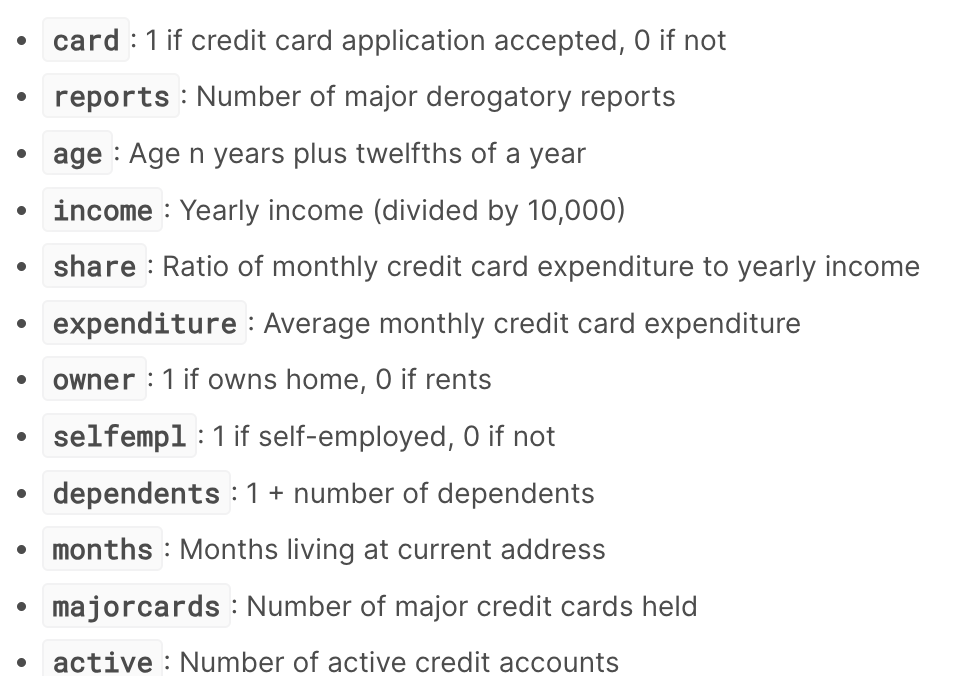


A few variables look suspicious. For example, does **`expenditure`** mean expenditure on this card or on cards used before applying?

At this point, basic data comparisons can be very helpful:

In [19]:
expenditures_noncardholders = X.expenditure[~y]
expenditures_cardholders = X.expenditure[y]


print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


As shown above, everyone who did not receive a card had no expenditures, while only 2% of those who received a card had no expenditures. It's not surprising that our model appeared to have a high accuracy. But this also seems to be a case of **target leakage**, where expenditures probably means expenditures on the card they applied for.

Since `share` is partially determined by `expenditure`, it should be excluded too. The variables `active` and `majorcards` are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

We would run a model without target leakage as follows:

In [20]:
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.830168


This accuracy is quite a bit lower, which might be disappointing. However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

## Conclusion

Data leakage can be multi-million dollar mistake in many data science applications. Careful separation of training and validation data can prevent train-test contamination, and pipelines can help implement this separation. Likewise, a combination of caution, common sense, and data exploration can help identify target leakage.
